In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if '.csv' in filename:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-emails/spam.csv


# Open csv file

In [2]:
df = pd.read_csv('/kaggle/input/spam-emails/spam.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# File preview

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Import libraries for text preprocessing

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy 

# Preprocess the text

In [5]:
def cleaning_df(df, series_name):

    # Cleaning using regex
    df[series_name] = df[series_name].apply(lambda x: x.lower())
    df[series_name] = df[series_name].apply(lambda x: re.findall(r'[a-z]+', x))
    
    # Removing stopwords
    stop_word = stopwords.words('english')
    df[series_name] = df[series_name].apply(lambda x: [i for i in x if i not in stop_word])
    
    # Transforming using lemmatizer
    nlp = spacy.load('en_core_web_sm') 
    df[series_name] = df[series_name].apply(lambda x: nlp(" ".join(x)))
    df[series_name] = df[series_name].apply(lambda x: [i.lemma_ for i in x])
    
    # Transforming using stemmer
    stemmer = PorterStemmer()
    df[series_name] = df[series_name].apply(lambda x: [stemmer.stem(i) for i in x])
    
    # Finally, merging all tokens
    df[series_name] = df[series_name].apply(lambda x: " ".join(x))

In [6]:
cleaning_df(df, 'Message')

# Text preview after preprocessing

In [7]:
df['Message']

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri wkli comp win fa cup final tkt st m...
3                     u dun say earli hor u c alreadi say
4                     nah think go usf live around though
                              ...                        
5567    nd time tri contact u u pound prize claim easi...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object

# Import libraries for tokenizing and sequencing

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-02-22 08:01:50.251434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 08:01:50.251686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 08:01:50.436877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Tokenize and sequence the text

In [9]:
def tf_processing(corpus):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    
    total_words = len(tokenizer.word_index) + 1
    maxlen = max([len(x) for x in sequences])
    sequences = pad_sequences(sequences, maxlen=maxlen)

    return sequences, total_words, maxlen

# Make the feature and label data

In [10]:
x, total_words, maxlen = tf_processing(df['Message'])
y = df['Category'].replace({'ham':0, 'spam':1})

/tmp/ipykernel_19/3433632891.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Category'].replace({'ham':0, 'spam':1})


# Import lib for train test split

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into train test split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25)

# Import libraries for making model

In [13]:
from tensorflow.keras import layers, Model, Input, optimizers, callbacks

# Make the model

In [14]:
inputs = Input(shape=(maxlen,))
embedding = layers.Embedding(total_words, 100, input_length=maxlen)(inputs)
x = layers.Bidirectional(layers.LSTM(128))(embedding)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(0.0001),
              metrics=['accuracy'])

# Make callback

In [15]:
class myCallback(callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            self.model.stop_training =True

# Train the model with callbacks and test data

In [16]:
callback = myCallback()
history = model.fit(x_train, y_train,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=callback)

Epoch 1/100
131/131 [==============================] - 27s 171ms/step - loss: 0.4201 - accuracy: 0.8653 - val_loss: 0.2885 - val_accuracy: 0.8679
Epoch 2/100
131/131 [==============================] - 22s 164ms/step - loss: 0.2031 - accuracy: 0.9239 - val_loss: 0.1373 - val_accuracy: 0.9777
Epoch 3/100
131/131 [==============================] - 21s 164ms/step - loss: 0.0799 - accuracy: 0.9823 - val_loss: 0.0649 - val_accuracy: 0.9828
Epoch 4/100
131/131 [==============================] - 21s 164ms/step - loss: 0.0412 - accuracy: 0.9890 - val_loss: 0.0515 - val_accuracy: 0.9821
Epoch 5/100
131/131 [==============================] - 22s 167ms/step - loss: 0.0271 - accuracy: 0.9928 - val_loss: 0.0530 - val_accuracy: 0.9799


# Import lib for plotting

In [17]:
import matplotlib.pyplot as plt

# Plot the training logs

Text(0.5, 1.0, 'loss')

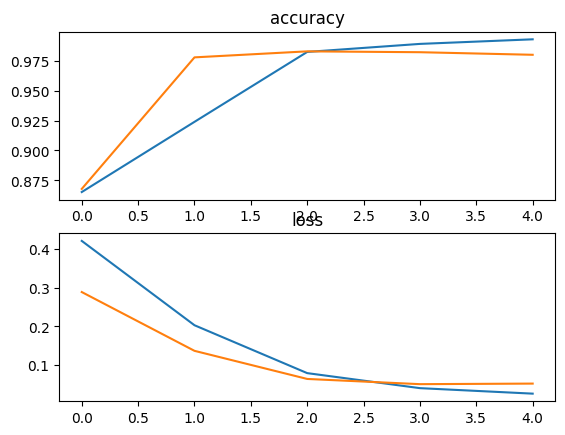

In [18]:
fig, ax = plt.subplots(2)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('accuracy')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('loss')

# Save the model into .h5 extension

In [19]:
model.save('spam_detector.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
